In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.absolute()))

from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astromodule.pipeline import Pipeline, PipelineStorage
from astromodule.table import concat_tables
from pylegs.io import read_table, write_table
from scipy.stats import gaussian_kde
from tqdm import tqdm

from splusclusters.configs import configs
from splusclusters.loaders import (LoadClusterInfoStage, LoadLegacyRadialStage,
                                   LoadPhotozRadialStage, LoadSpeczRadialStage,
                                   load_clusters, load_members_index_v6,
                                   load_photoz, load_spec)
from splusclusters.match import (PhotoZRadialSearchStage,
                                 PhotozSpeczLegacyMatchStage,
                                 SpecZRadialSearchStage)
from splusclusters.plots import ClusterPlotStage
from splusclusters.utils import compute_pdf_peak, relative_err, rmse
from splusclusters.website import WebsitePagesStage
from matplotlib.ticker import MaxNLocator

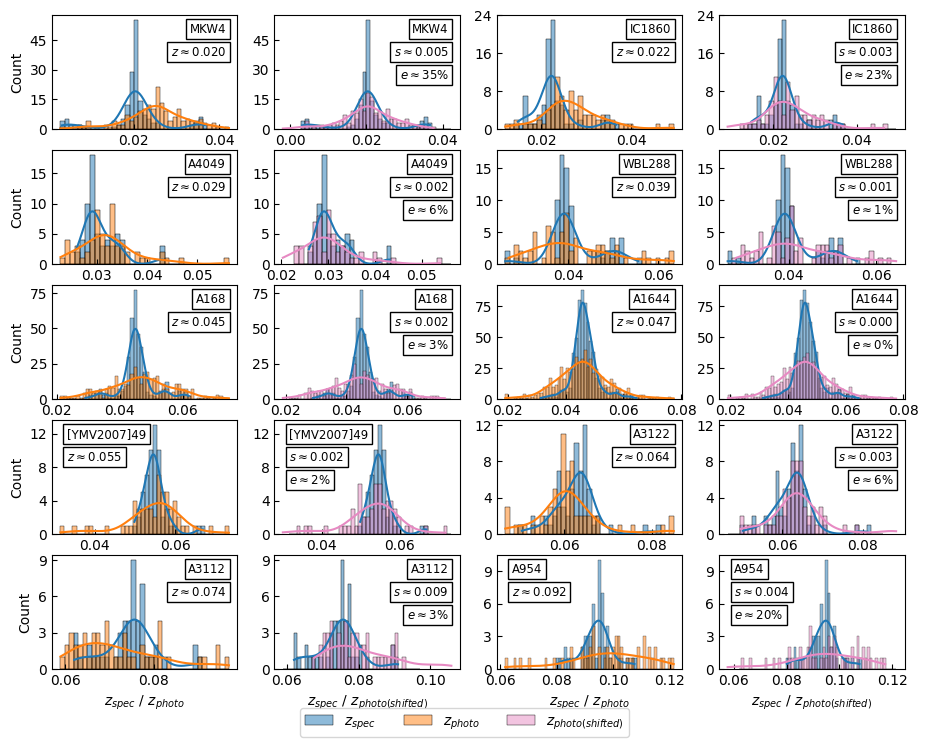

In [10]:
def create_zoffset_plots(z_delta: float = 0.02, overwrite: bool = False):
  df_clusters = load_members_index_v6()
  df_paper = read_table(configs.ROOT / 'tables' / 'z_offset_paper.csv')
  df_paper = df_paper[df_paper.AstroInspectClass == 'bom']
  del df_paper['ra']
  del df_paper['dec']
  df_clusters = df_paper.set_index('name').join(df_clusters.set_index('name'), on='name').reset_index()
  
  fig, axs = plt.subplots(5, 4, figsize=(11, 8.5)) # (11, 13)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.18) # 0.18
  
  text_places = ['right', 'right', 'right', 'right', 'right', 'right', 'left', 'right', 'right', 'left']
  def get_text_pos(idx):
    if text_places[idx] == 'left':
      return dict(x=0.08, y=0.93, ha='left')
    return dict(x=0.94, y=0.93, ha='right')
  
  for idx, row in df_clusters.iterrows():
    z_cluster = row['z_spec']
    r200_Mpc = row['R200_Mpc']
    cls_id = row['clsid']
    name = row['name']
    n_memb = row['Nmemb']
    
    zoffset = read_table(configs.Z_OFFSET_TABLE_PATH)
    zoffset = zoffset[zoffset['name'] == name]
    if len(zoffset) == 0: 
      print('>> Skiped\n')
      continue
    zoffset = zoffset.iloc[0]
    
    path = configs.PHOTOZ_SPECZ_LEG_FOLDER / f'{name}.parquet'
    df = read_table(path)
    mask = (
      (df.flag_member.isin([0, 1])) & 
      (df.z.between(z_cluster-z_delta, z_cluster+z_delta)) &
      (df.zml.between(z_cluster-0.03, z_cluster+0.03)) &
      (df.radius_Mpc < 5*r200_Mpc)
    )
    df = df[mask]
    
    x_min = min(df.zml.min(), df.z.min())
    x_max = max(df.zml.max(), df.z.max())
    binrange = (x_min, x_max)
    
    row = int(np.floor(idx / 2))
    col = int(idx % 2) * 2
    
    lbl1 = dict(label='$z_{{spec}}$') if row == 0 else dict()
    lbl2 = dict(label='$z_{{photo}}$') if row == 0 else dict()
    sns.histplot(x=df.z.values, binrange=binrange, binwidth=0.001, kde=True, **lbl1, ax=axs[row, col])
    sns.histplot(x=df.zml.values, binrange=binrange, binwidth=0.001, kde=True, **lbl2, ax=axs[row, col])
    x = get_text_pos(idx)['x']
    y = get_text_pos(idx)['y']
    ha = get_text_pos(idx)['ha']
    axs[row, col].text(x=x, y=y, ha=ha, s=name, size=8.5, va='top', bbox={'boxstyle': 'square', 'fc': 'white'}, transform=axs[row, col].transAxes)
    axs[row, col].text(x=x, y=y-0.20, ha=ha, s=f'$z \\approx {z_cluster:.3f}$', size=8.5, va='top', bbox={'boxstyle': 'square', 'fc': 'white'}, transform=axs[row, col].transAxes)
    # axs[row, col].set_title(name, size=10.1, pad=1)
    axs[row, col].tick_params(direction='in')
    axs[row, col].yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    if col != 0: axs[row, col].set_ylabel(None)
    if row == 4: axs[row, col].set_xlabel('$z_{{spec}}$ / $z_{{photo}}$')
    
    col += 1
    shift = zoffset['z_offset_mi']
    err = min(zoffset['rel_omi_mi'], zoffset['rel_omi_m']) * 100
    
    lbl3 = dict(label='$z_{{photo(shifted)}}$') if row == 0 else dict()
    sns.histplot(x=df.z.values, binrange=binrange, binwidth=0.001, kde=True, ax=axs[row, col])
    sns.histplot(x=df.zml.values - shift, binrange=binrange, binwidth=0.001, kde=True, color=sns.color_palette("Set2")[3], **lbl3, ax=axs[row, col])
    axs[row, col].text(x=x, y=y, ha=ha, s=name, size=8.5, va='top', bbox={'boxstyle': 'square', 'fc': 'white'}, transform=axs[row, col].transAxes)
    axs[row, col].text(x=x, y=y-0.20, ha=ha, s=f'$s \\approx {abs(shift):.3f}$', size=8.5, va='top', bbox={'boxstyle': 'square', 'fc': 'white'}, transform=axs[row, col].transAxes)
    axs[row, col].text(x=x, y=y-0.40, ha=ha, s=f'$e \\approx {abs(err):.0f}$%', size=8.5, va='top', bbox={'boxstyle': 'square', 'fc': 'white'}, transform=axs[row, col].transAxes)
    # axs[row, col].set_title(name, size=10.1, pad=1)
    axs[row, col].tick_params(direction='in')
    axs[row, col].yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    axs[row, col].set_ylabel(None)
    if row == 4: axs[row, col].set_xlabel('$z_{{spec}}$ / $z_{{photo(shifted)}}$')
    
    if row == 0:
      h1, l1 = axs[row, col-1].get_legend_handles_labels()
      h2, l2 = axs[row, col].get_legend_handles_labels()
      h, l = [*h1, *h2], [*l1, *l2]
  
  fig.legend(h, l, loc='lower center', bbox_to_anchor=(0.5, 0.022), fancybox=True, shadow=False, ncol=3)
  plt.savefig('zoffset.pdf', bbox_inches='tight', pad_inches=0.01)


create_zoffset_plots()